In [1]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\distributed\utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10065] A socket operation was attempted to an unreachable host
  % (host, default, e), RuntimeWarning)


Create data frame of annotation info

In [41]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(959, 13)
Int64Index([], dtype='int64')
(959, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,527,cagepair,18922.5,high slug,44921.600,0.335974,40617.050954,117729.192000,6.831866,48.160918,0.000787,38586.198407
1,1,527,cagepair,24750.0,low slug,53212.637,0.295599,27042.548508,3827.200195,3.556462,20.402396,-0.000227,25690.421083
2,2,527,cagepair,56002.5,bbc,94253.766,0.189555,30090.095178,68103.292456,3.982554,18.393372,-0.002314,28585.590419
3,3,527,cagepair,174352.5,bbc,51008.836,0.306177,34324.170621,52563.703613,3.336529,10.448164,-0.001250,32607.962090
4,4,527,cagepair,342877.5,bbc,164846.110,0.144833,33090.921412,22861.514782,1.852232,3.185318,-0.001784,31436.375341


In [43]:
annot_features_full = annot_features_full[(annot_features_full['Annotation'] == 'rand_noise') | (annot_features_full['Annotation'] == 'low slug')]
annot_features_full.shape

(860, 13)

In [44]:
#separate and save for later testing dataset
train_orig, test_orig = train_test_split(annot_features_full, test_size=0.3, random_state=1, stratify = annot_features_full.Annotation)

In [45]:
train_orig_maj = train_orig[train_orig['Annotation'] == 'rand_noise']
train_orig_min = train_orig[train_orig['Annotation'] != 'rand_noise']

train_orig_min_upsamples = resample(train_orig_min, replace=True, n_samples = len(train_orig_maj), random_state = 123)

train_orig_upsamples = pd.concat([train_orig_min_upsamples, train_orig_maj])

print(train_orig_upsamples.Annotation.value_counts())

train_orig_upsamples.head()

rand_noise    560
low slug      560
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
45,45,535,CPApair,163980.0,low slug,54674.074,0.260282,22905.679940,15434.301760,6.519813,47.643695,-0.000584,21760.395943
53,53,535,CPApair,268065.0,low slug,71793.860,0.215367,22715.390550,7900.647133,4.331384,22.261247,-0.000691,21579.621023
121,121,555,CPApair,260842.5,low slug,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
16,16,533,CPApair,149692.5,low slug,43037.465,0.306856,37931.297975,20543.321215,4.308415,22.308306,-0.000239,36034.733076
17,17,533,CPApair,243157.5,low slug,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566


In [46]:
groups = train_orig_upsamples['Unnamed: 0'].values
annot_labels_up = train_orig_upsamples['Annotation']
annot_labels_up = annot_labels_up.replace(regex={r'low slug': 1, 'rand_noise': 0})
print(annot_labels_up.value_counts())

1    560
0    560
Name: Annotation, dtype: int64


In [47]:
annot_features_up = train_orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
annot_features_up.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
45,54674.074,0.260282,22905.679940,15434.301760,6.519813,47.643695,-0.000584,21760.395943
53,71793.860,0.215367,22715.390550,7900.647133,4.331384,22.261247,-0.000691,21579.621023
121,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
16,43037.465,0.306856,37931.297975,20543.321215,4.308415,22.308306,-0.000239,36034.733076
17,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566


In [48]:
group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(annot_features_up, annot_labels_up, groups))

In [49]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

In [50]:
lr_cv = LogisticRegression(random_state=0)
rf_cv = RandomForestClassifier(max_depth=10, random_state=0)
svm_cv = SVC(probability=True) 

In [51]:
y_pred_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(annot_labels_up, y_pred_lr)
conf_mat_lr

array([[454, 106],
       [148, 412]], dtype=int64)

In [52]:
y_pred_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(annot_labels_up, y_pred_rf)
conf_mat_rf

array([[552,   8],
       [325, 235]], dtype=int64)

In [53]:
y_pred_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(annot_labels_up, y_pred_svm)
conf_mat_svm

array([[458, 102],
       [134, 426]], dtype=int64)

In [57]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_lr, average='weighted'))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_lr, average='weighted'))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_lr))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_lr, average='weighted'))

Sensitivity/Recall (TPR):  0.7732142857142857
Precision (PPV):  0.7747598096435305
Accuracy:  0.7732142857142857
F1: 0.7728949191944028


In [58]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_rf, average='weighted'))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_rf, average='weighted'))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_rf))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_rf, average='weighted'))

Sensitivity/Recall (TPR):  0.7026785714285714
Precision (PPV):  0.7982483306821329
Accuracy:  0.7026785714285714
F1: 0.6767861646175486


In [59]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_svm, average='weighted'))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_svm, average='weighted'))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_svm))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_svm, average='weighted'))

Sensitivity/Recall (TPR):  0.7892857142857143
Precision (PPV):  0.7902334152334153
Accuracy:  0.7892857142857143
F1: 0.7891135620915033


In [60]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.8783418367346939
Random forest ROC_AUC:  0.865671237244898
SVM ROC_AUC:  0.8658577806122448


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

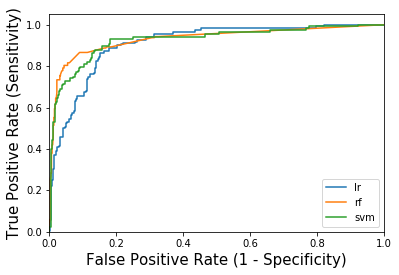

In [20]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(annot_labels_up, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(annot_labels_up, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

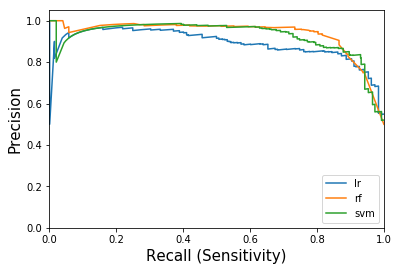

In [21]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

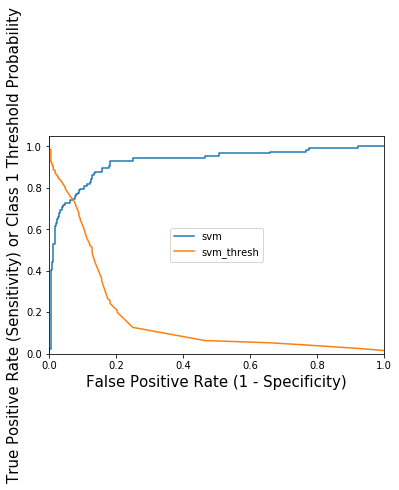

In [22]:
# plot LR and RF model ROC curves
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_svm, thresholds_svm, label="svm_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [23]:
train_orig_upsamples['pred_lr'] = y_pred_prob_lr[:,1]
train_orig_upsamples['pred_rf'] = y_pred_prob_rf[:,1]
train_orig_upsamples['pred_svm'] = y_pred_prob_svm[:,1]
train_orig_upsamples['class_actual'] = annot_labels_up
train_orig_upsamples['class_svm'] = y_pred_svm
train_orig_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred_lr,pred_rf,pred_svm,class_actual,class_svm
145,145,557,cagepair,21352.5,bbc,65597.030,0.269421,31855.366205,69503.004103,3.889467,14.647099,-0.001683,30262.597895,0.947414,0.992913,0.871924,1,1
0,0,527,cagepair,18922.5,high slug,44921.600,0.335974,40617.050954,117729.192000,6.831866,48.160918,0.000787,38586.198407,0.760375,0.500000,0.515285,1,1
66,66,535,CPApair,442507.5,low slug,29249.727,0.405450,33752.490637,7771.129294,2.825502,14.031428,-0.000010,32064.866105,0.312171,0.300000,0.126257,1,0
112,112,554,CPApair,363622.5,high slug,33684.504,0.370857,55862.628293,338791.203147,7.272298,54.994959,0.002021,53069.496878,0.991178,0.300000,0.819076,1,1
81,81,541,cagepair,591255.0,bbc,655520.750,0.028150,31762.963636,75837.588445,3.056477,9.180092,-0.002566,30174.815454,0.937769,0.993920,0.967092,1,1


In [24]:
train_orig_upsamples.groupby('Annotation')['pred_lr', 'pred_rf', 'pred_svm'].describe()

pred_lr                                                                       pred_rf                                                                       pred_svm                                                                      
             count      mean       std       min       25%       50%       75%       max   count      mean       std       min       25%       50%       75%       max    count      mean       std       min       25%       50%       75%       max
Annotation                                                                                                                                                                                                                                           
bbc          167.0  0.878804  0.161989  0.560513  0.749365  0.975485  0.994265  0.997792   167.0  0.951238  0.082517  0.666667  0.966667  0.992720  0.993920  1.000000    167.0  0.934322  0.051232  0.796057  0.896208  0.960614  0.970200  0.993679
high multi    19.0  0.947887  0.062736  0.858508  0.858508  0.981917  0.997564  0.997564    19.0  0.384211  0.201650  0.200000  0.200000  0.300000  0.666667  0.666667     19.0  0.879327  0.039974  0.825264  0.825264  0.887511  0.918651  0.918651
high slug     97.0  0.741168  0.270472  0.054931  0.568249  0.801668  0.991178  0.999960    97.0  0.692098  0.309337  0.100000  0.500000  0.887006  0.900000  1.000000     97.0  0.702615  0.249954  0.199197  0.515285  0.758245  0.891420  0.990282
low multi     80.0  0.817134  0.113899  0.405111  0.785280  0.843444  0.904068  0.948464    80.0  0.792096  0.269603  0.057143  0.787006  0.887006  0.985459  0.996323     80.0  0.853029  0.189565  0.257175  0.859457  0.918775  0.954009  0.989521
low slug     197.0  0.617948  0.243377  0.052213  0.536109  0.658485  0.766681  0.981728   197.0  0.576869  0.363450  0.000000  0.300000  0.692208  0.892913  0.996514    197.0  0.652539  0.336475  0.024824  0.455946  0.845640  0.905009  0.968385
rand_noise   560.0  0.237196  0.254079  0.010693  0.061573  0.101486  0.341691  0.999920   560.0  0.080657  0.170888  0.000000  0.000000  0.000000  0.100000  0.996514    560.0  0.166109  0.238057  0.014597  0.043831  0.060788  0.124708  0.989375

In [25]:
preds = []
for index, row in train_orig_upsamples.iterrows():
    if (row['class_actual'] == 0) & (row['class_svm'] == 0):
        pred = 'TN'
    if (row['class_actual'] == 0) & (row['class_svm'] == 1):
        pred = 'FP'
    if (row['class_actual'] == 1) & (row['class_svm'] == 1):
        pred = 'TP'
    if (row['class_actual'] == 1) & (row['class_svm'] == 0):
        pred = 'FN'
    preds.append(pred)
    
train_orig_upsamples['pred'] = preds

In [26]:
train_orig_upsamples.groupby('pred').describe()

Unnamed: 0                                                            animal_number                                                            time_stamp                                                                                     power_sum                                                                                              spec_pur                                                                       spec_cent                                                                                                  spec_spread                                                                                                    spec_skew                                                                       spec_kurt                                                                             spec_slope                                                                       spec_roll                                                                                                   \
          count        mean         std   min    25%    50%     75%    max         count        mean        std    min     25%    50%    75%    max      count           mean            std      min         25%        50%         75%       max     count           mean           std        min          25%          50%           75%          max    count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%           max       count          mean           std          min           25%           50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std       min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%           max   
pred                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
FN         76.0   64.907895   40.500923   7.0   42.0   55.0  100.00  142.0          76.0  540.144737   9.660509  529.0  535.00  535.0  553.0  556.0       76.0  254211.513158  157532.199686  23332.5  134499.375  266265.00  370417.500  546525.0      76.0   57351.955461  3.340073e+04  29249.727  36765.04000   46576.0100   51548.09800    152051.89     76.0  0.302465  0.073161  0.159031  0.265496  0.322633  0.345318  0.405450      76.0  30846.497510  6086.333681  18326.598139  26105.311071  31209.480023  33752.490637  43426.554184        76.0  18033.426665  54054.248601  1961.889925   6992.203936   7745.730242   14951.713978  473261.796494      76.0  2.777136  1.348587  0.404790  2.345135  2.761751  3.350239  6.968576      76.0  12.311660  10.752535  1.068542   5.464365  11.316812  16.018402  50.396661       76.0 -0.000387  0.000648 -0.001969 -0.000764 -0.000202  0.000033  0.000519      76.0  29304.172634  5782.016997  17410.268232  24800.045517  29649.006022  32064.866105  41255.226475   
FP   

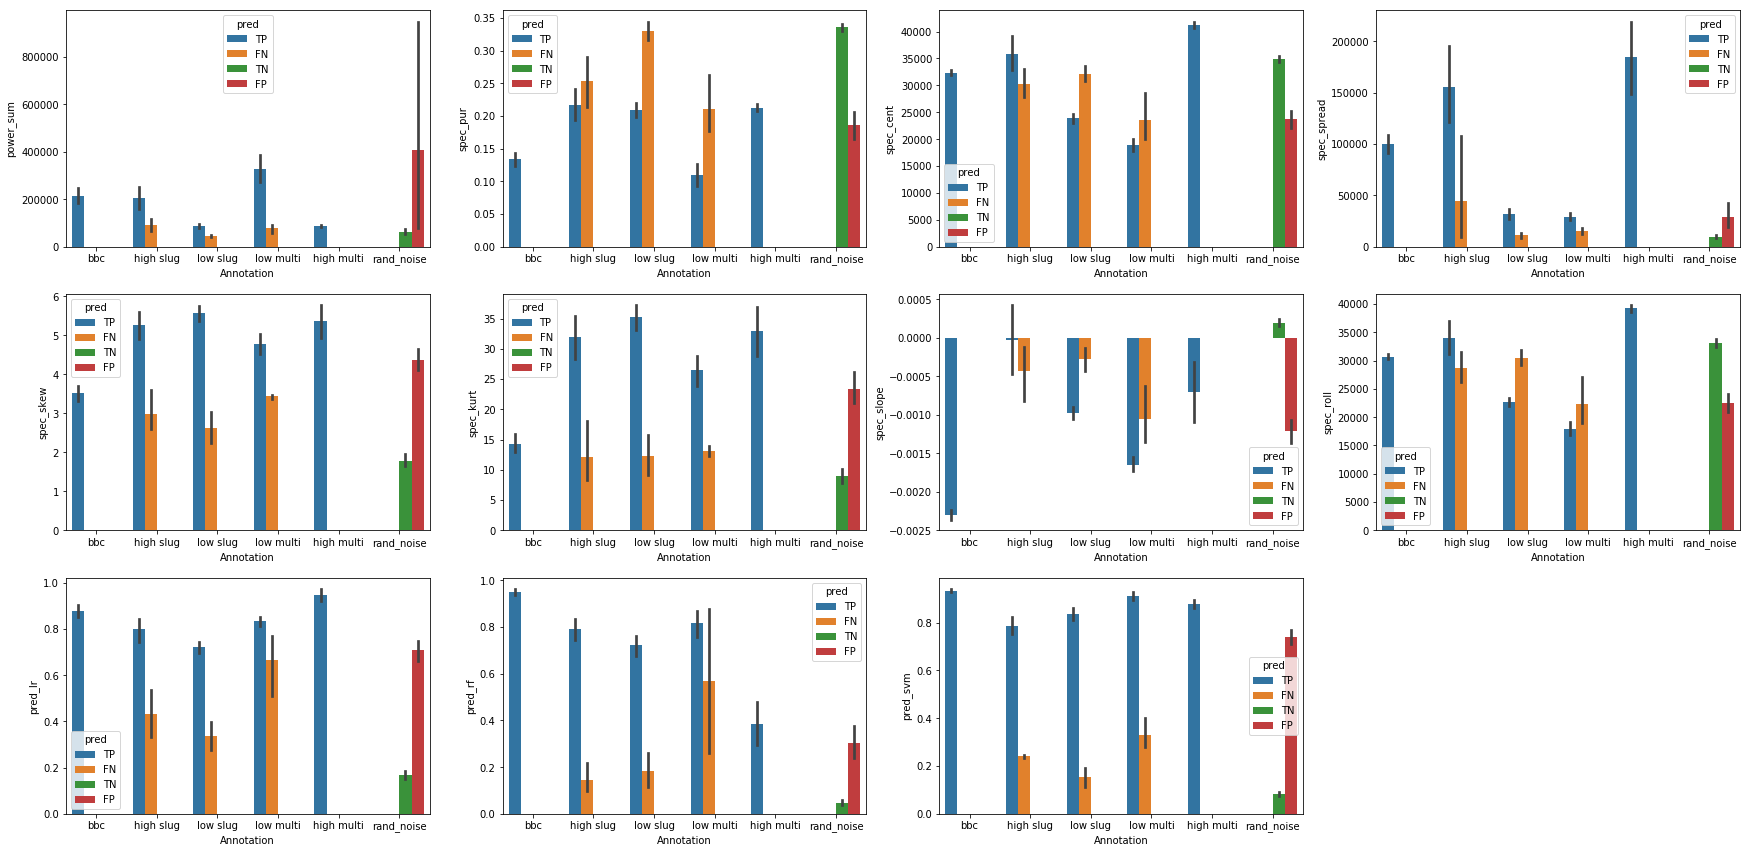

In [27]:
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_lr', 'pred_rf',
       'pred_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=train_orig_upsamples)
    i = i + 1

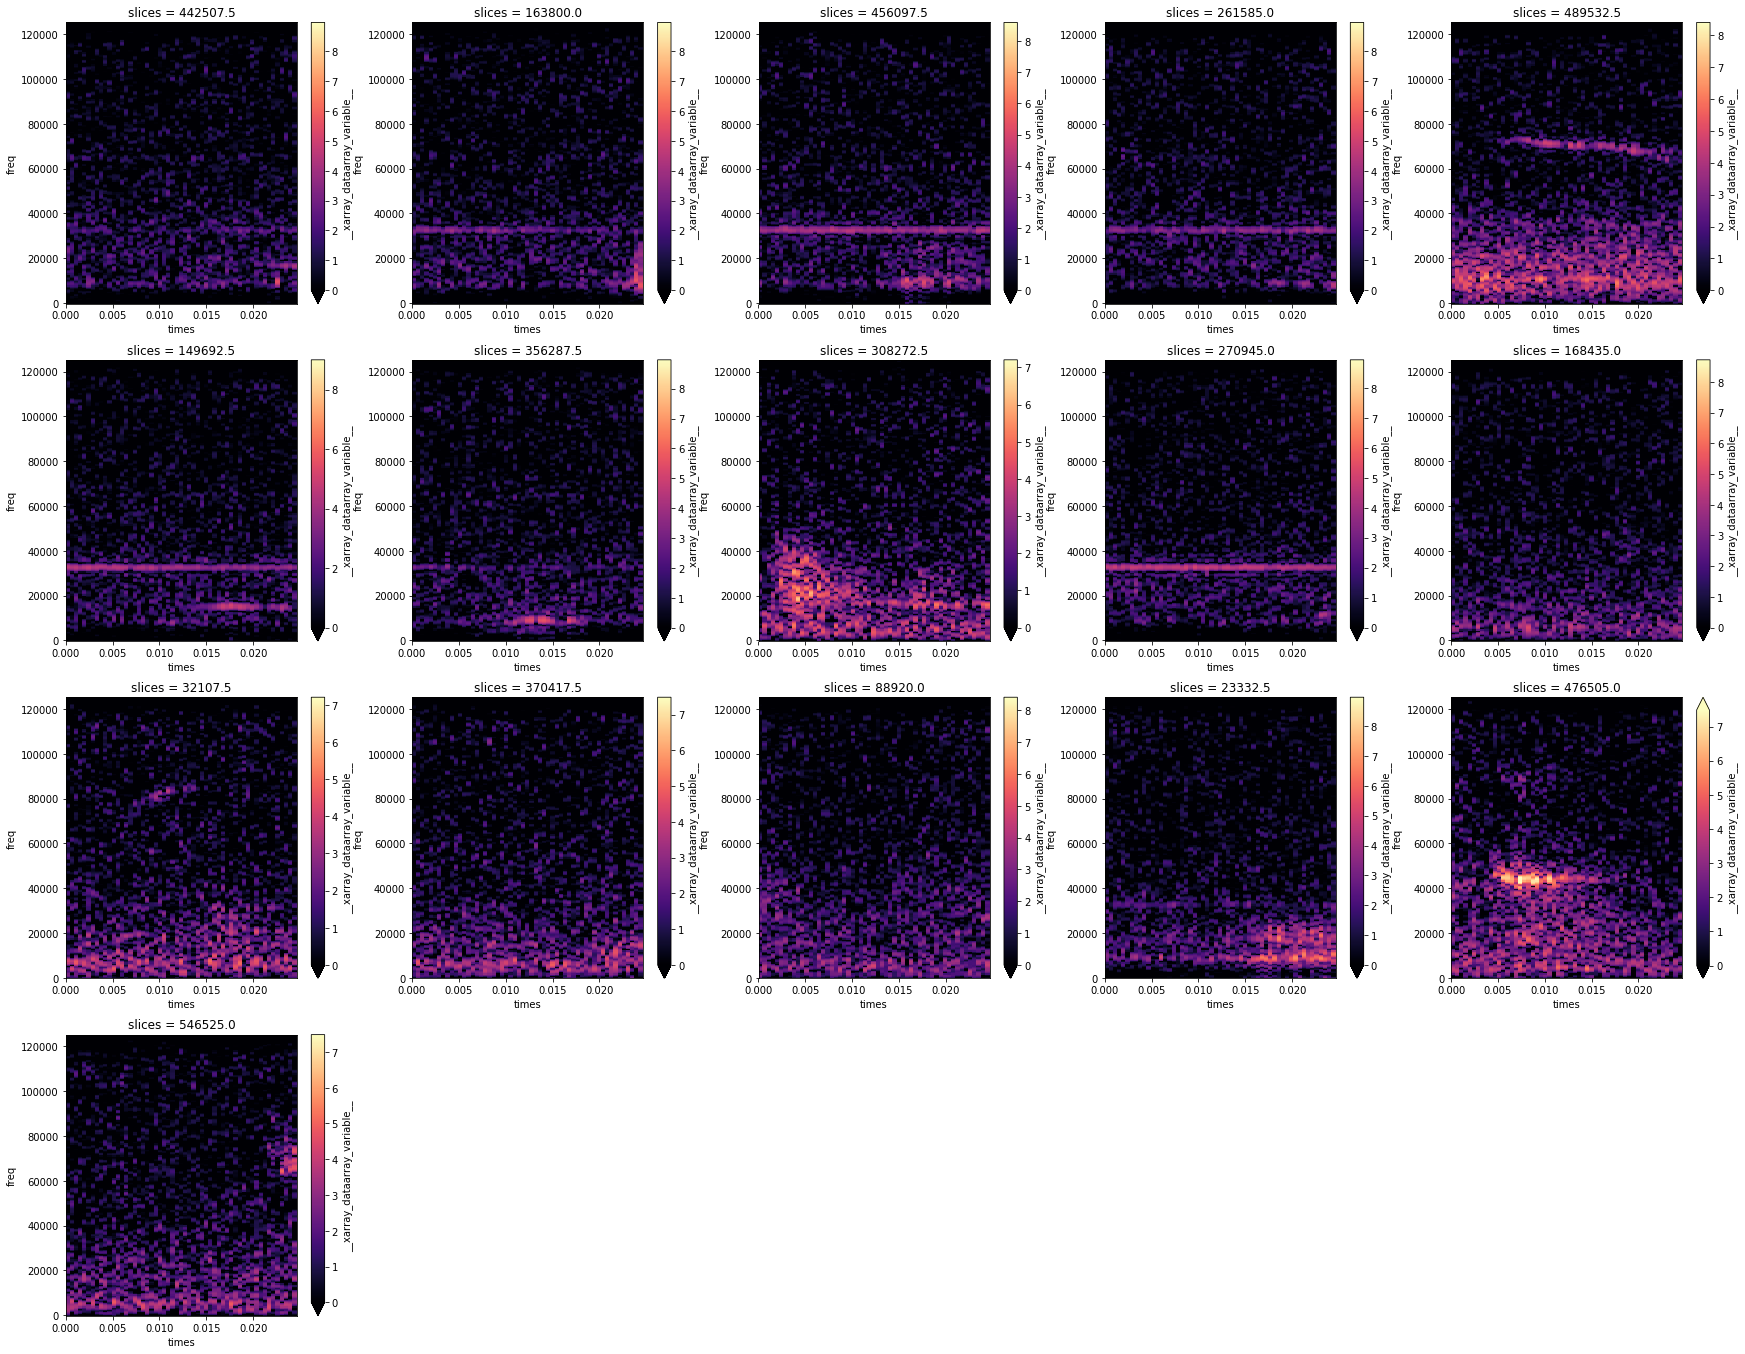

In [30]:
false_neg_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FN'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_neg_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(5, 5, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

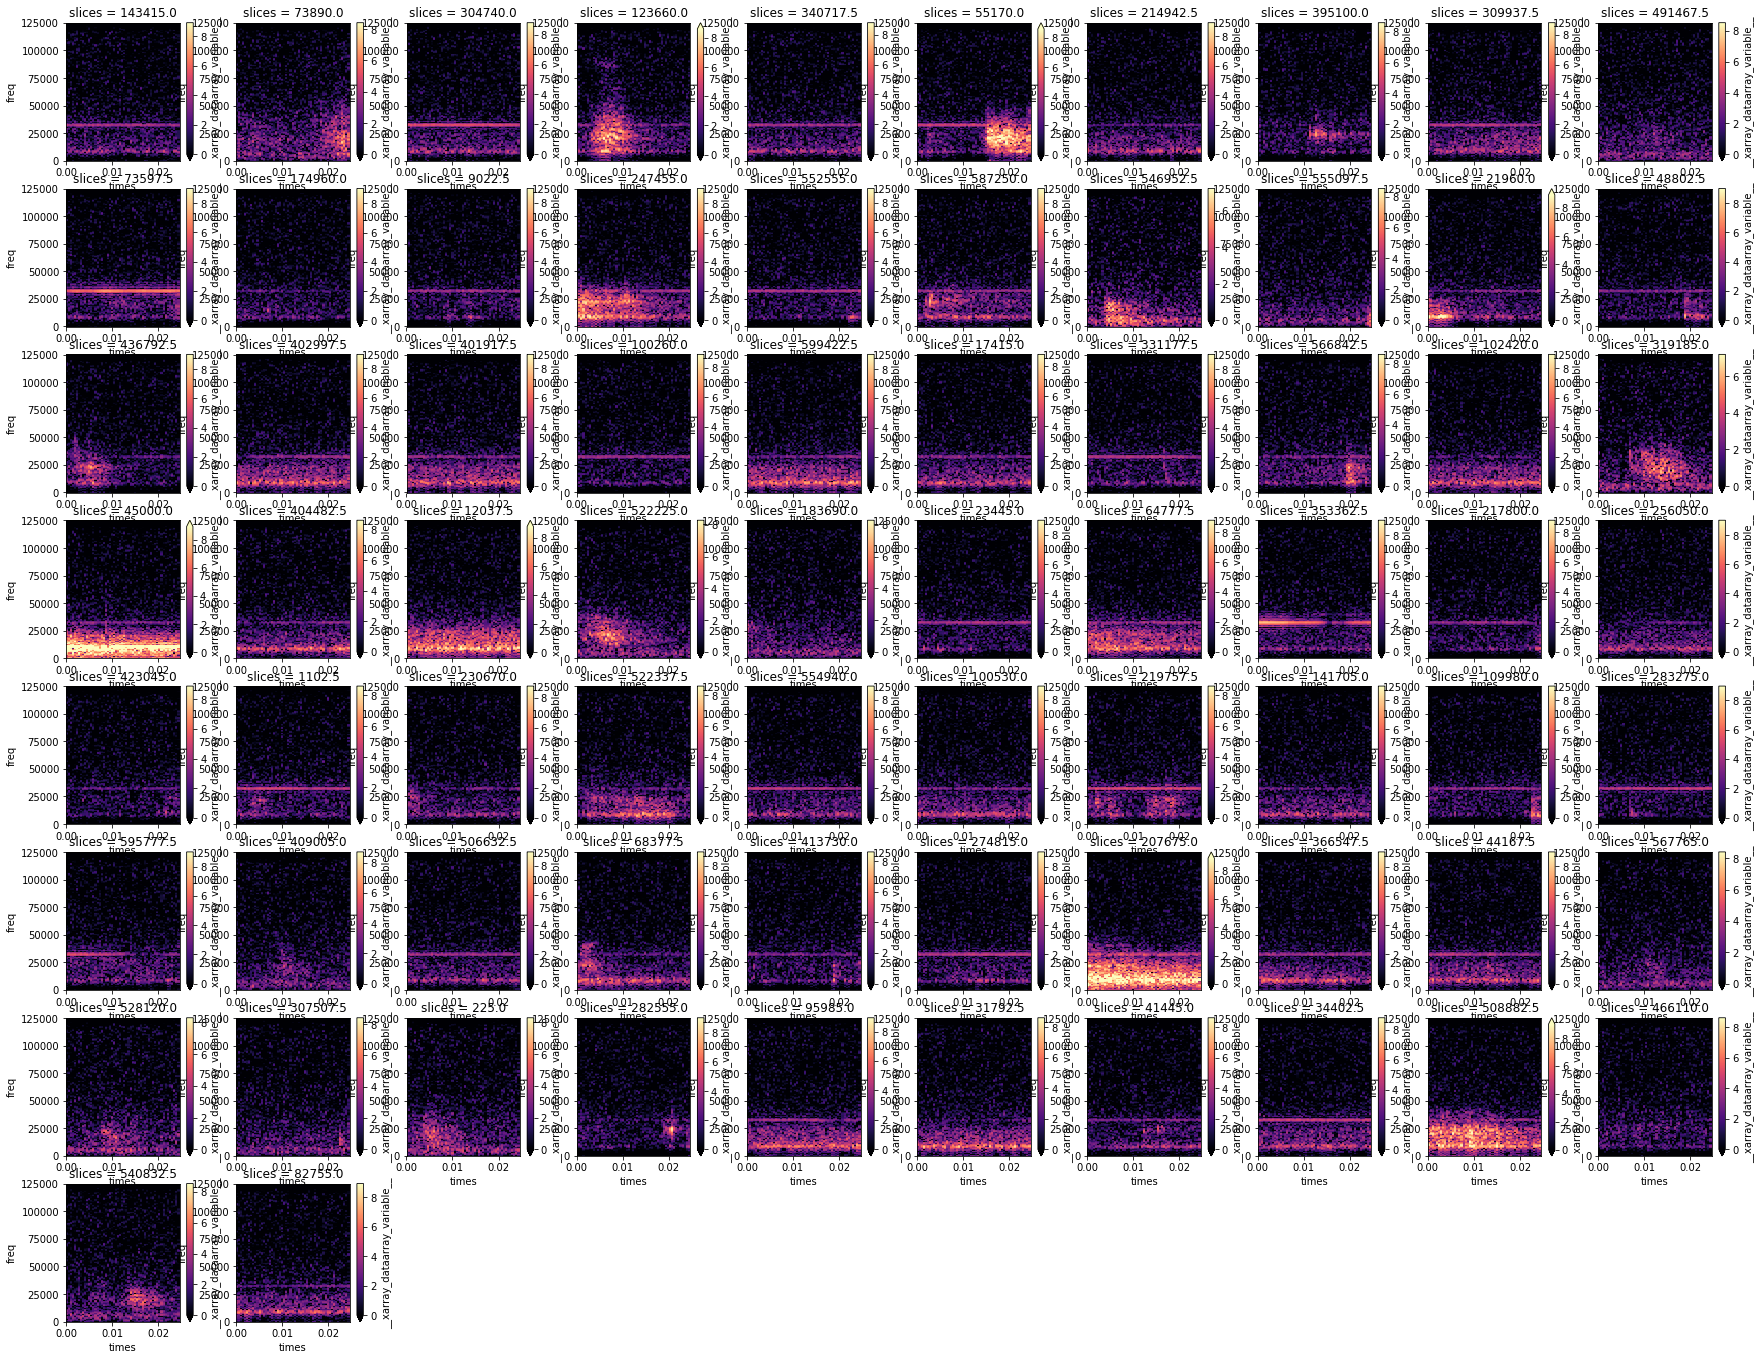

In [32]:
false_pos_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FP'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(10, 10, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1